# Loading Data

In [1]:
import os
from tqdm import tqdm
from PIL import Image
import torch
import pandas as pd
#from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

In [2]:
train_path = '../data/train'
validation_path = '../data/validation'
test_path = '../data/test'

num_train = sum([len(files) for r, d, files in os.walk(train_path)]) - 1 # ignore .DS_Store folder
num_validation = sum([len(files) for r, d, files in os.walk(validation_path)])
num_test = sum([len(files) for r, d, files in os.walk(test_path)])

image_categories = os.listdir(train_path)
image_categories = [cat for cat in image_categories if not cat.startswith('.')]

print(f'Number of training images: {num_train}')
print(f'Number of validation images: {num_validation}')
print(f'Number of testing images: {num_test}')
print(f'Number of classes: {len(image_categories)}')
print('Classes: ' + ', '.join(image_categories))

Number of training images: 15000
Number of validation images: 3000
Number of testing images: 3000
Number of classes: 15
Classes: Capsicum, Radish, Pumpkin, Cauliflower, Potato, Bean, Cucumber, Brinjal, Cabbage, Broccoli, Bitter_Gourd, Papaya, Bottle_Gourd, Tomato, Carrot


The images in the dataset consists of jpg images of size 224x224. We visualise them below.

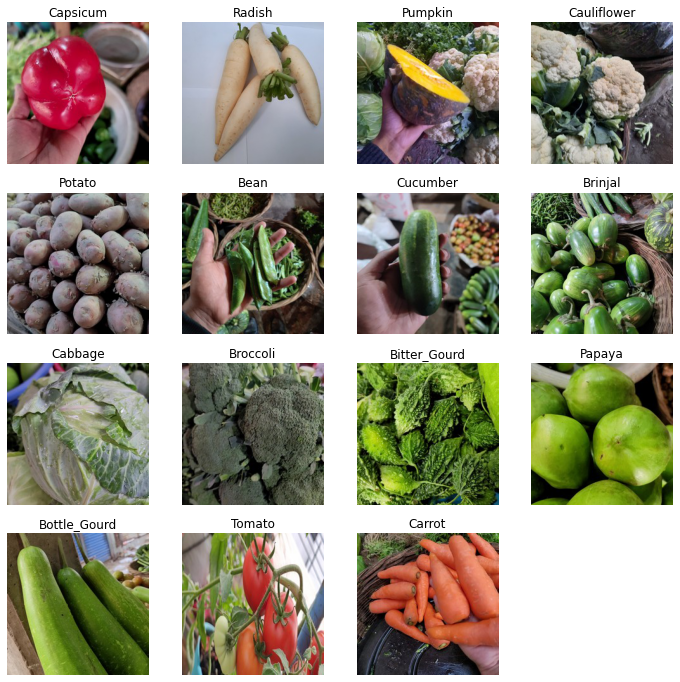

In [3]:
def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = Image.open(first_image_path)
        
        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Call the function
plot_images(image_categories)

We now try to import our dataset with the default dataloader.

In [4]:
train_data = datasets.ImageFolder(train_path, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

We can test our dataloader here.

# Training CNN

First we try to copy the architecture used here https://www.kaggle.com/code/chitwanmanchanda/vegetable-image-classification-using-cnn/notebook and translate from Tensorflow to PyTorch

We augment our transformation to normalize all colour channels in our images, and we resize images to 150x150 as in the above notebook.

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((150, 150)),
                                transforms.Normalize((0, 0, 0), (1, 1, 1))])

train_data = datasets.ImageFolder(train_path, transform=transform)
test_data = datasets.ImageFolder(test_path, transform=transform)
validation_data = datasets.ImageFolder(validation_path, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)

See if our dataloaders work.

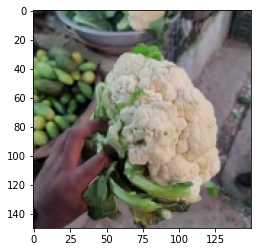

In [6]:
images, labels = next(iter(test_loader))
plt.imshow(images[31].permute(1, 2, 0))

torch.Size([3, 150, 150])
tensor([[[0.4706, 0.4677, 0.4676,  ..., 0.3882, 0.3880, 0.3873],
         [0.4735, 0.4706, 0.4698,  ..., 0.3889, 0.3851, 0.3821],
         [0.4745, 0.4745, 0.4715,  ..., 0.3899, 0.3875, 0.3852],
         ...,
         [0.5312, 0.5335, 0.5349,  ..., 0.3670, 0.3677, 0.3648],
         [0.5272, 0.5287, 0.5286,  ..., 0.3686, 0.3686, 0.3657],
         [0.5346, 0.5295, 0.5257,  ..., 0.3686, 0.3686, 0.3657]],

        [[0.6078, 0.6049, 0.6048,  ..., 0.5294, 0.5292, 0.5284],
         [0.6107, 0.6078, 0.6071,  ..., 0.5301, 0.5262, 0.5233],
         [0.6118, 0.6118, 0.6088,  ..., 0.5310, 0.5286, 0.5264],
         ...,
         [0.7195, 0.7217, 0.7232,  ..., 0.5647, 0.5647, 0.5618],
         [0.7155, 0.7169, 0.7169,  ..., 0.5647, 0.5647, 0.5618],
         [0.7228, 0.7177, 0.7140,  ..., 0.5647, 0.5647, 0.5618]],

        [[0.7333, 0.7304, 0.7303,  ..., 0.6706, 0.6703, 0.6696],
         [0.7362, 0.7333, 0.7326,  ..., 0.6713, 0.6674, 0.6645],
         [0.7373, 0.7373, 0.7342

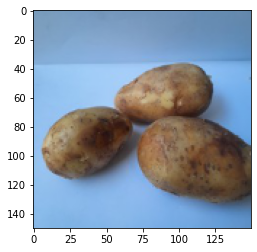

In [7]:
images, labels = next(iter(train_loader))
print(images[0].shape)
print(images[0])
print(labels)
plt.imshow(images[0].permute(1, 2, 0))
print(labels[0])

We define our neural network.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d((2,2))
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d((2, 2))
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(37 * 37 * 64, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        
        #self.dropout = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(128, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 15)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.pool2(x)
        
        x = self.flatten(x)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        #x = self.dropout(x)
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.softmax(self.fc3(x), dim=1)
        return x

net = Net()


#if torch.cuda.is_available():
#    net = net.cuda()

Define loss function and optimiser.

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-07)

Train the network.

In [11]:
epochs = 2

In [12]:
for epoch in range(epochs): 

    train_loss = 0.0
    for data in tqdm(train_loader):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)}')

# Save model for future
torch.save(net.state_dict(), 'vegetables_net_fullbn_lr_1e-02.pth')
print('Finished Training')

100%|█████████████████████████████████████████| 469/469 [07:43<00:00,  1.01it/s]


Epoch 1 		 Training Loss: 2.226835760734737


100%|█████████████████████████████████████████| 469/469 [22:45<00:00,  2.91s/it]

Epoch 2 		 Training Loss: 2.05400224408107
Finished Training


We can later reload the model like this.

In [13]:
# Reload model like this
# net = Net()
# net.load_state_dict(torch.load('vegetables_net.pth'))

# Testing CNN

Calculate training accuracy.

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(train_loader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {num_train} training images: {100 * correct // total} %')

100%|█████████████████████████████████████████| 469/469 [03:31<00:00,  2.22it/s]

Accuracy of the network on the 15000 training images: 83 %


Calculate testing accuracy.

In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {num_test} test images: {100 * correct // total} %')

100%|███████████████████████████████████████████| 94/94 [00:32<00:00,  2.87it/s]

Accuracy of the network on the 3000 test images: 81 %


# Adding Validation Loop

In [47]:
net2 = Net()

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(net2.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-07)

In [56]:
max_valid_loss = np.inf

for epoch in range(epochs):
    train_loss = 0.0
    net2.train(True)
    for data in tqdm(train_loader):
        inputs, labels = data

        # zero the parameter gradients
        optimizer2.zero_grad()
        
        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    net2.train(False)
    for vdata in tqdm(validation_loader):
        vinputs, vlabels = vdata
    
        voutputs = net2(vinputs)
        vloss = criterion(voutputs, vlabels)
        valid_loss += vloss.item()
        
    avg_vloss = valid_loss / len(validation_loader)

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {avg_vloss}')
    if avg_vloss < max_valid_loss:
        print(f'Validation Loss Decreased({max_valid_loss:.6f}--->{avg_vloss:.6f}) \t Saving The Model')
        max_valid_loss = avg_vloss
        torch.save(net2.state_dict(), 'vegetable_net_fullbn_validation_lr_1e-02.pth')
print('Finished Training')

100%|███████████████████████████████████████████| 94/94 [00:31<00:00,  2.94it/s]


Epoch 1 		 Training Loss: 2.253048593047331 		 Validation Loss: 2.213900809592389
Validation Loss Decreased(inf--->2.213901) 	 Saving The Model


100%|███████████████████████████████████████████| 94/94 [00:30<00:00,  3.04it/s]

Epoch 2 		 Training Loss: 2.036403727429762 		 Validation Loss: 2.0766770269008394
Validation Loss Decreased(2.213901--->2.076677) 	 Saving The Model
Finished Training


Testing network trained with validation.

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {num_test} test images: {100 * correct // total} %')

 32%|█████████████▋                             | 30/94 [00:09<00:20,  3.19it/s]

# Increasing Speed and Accuracy

In [20]:
transformSmall = transforms.Compose([transforms.Resize((64, 64)),
                                       transforms.ToTensor()])

train_dataSmall = datasets.ImageFolder(train_path, transform=transformSmall)
test_dataSmall = datasets.ImageFolder(test_path, transform=transformSmall)
validation_dataSmall = datasets.ImageFolder(validation_path, transform=transformSmall)

train_loaderSmall = torch.utils.data.DataLoader(train_dataSmall, batch_size=64, shuffle=True)
test_loaderSmall = torch.utils.data.DataLoader(test_dataSmall, batch_size=64, shuffle=False)
validation_loaderSmall = torch.utils.data.DataLoader(validation_dataSmall, batch_size=32, shuffle=True)

In [21]:
class ImprovedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*32*32, 64)
        self.fc2 = nn.Linear(64, 15)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

improvedNet = ImprovedNet()

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improvedNet.parameters(), lr = 0.01, betas=(0.9, 0.999), eps=1e-07)

In [23]:
epochs = 10

In [24]:
#for epoch in range(epochs): 
#
#    train_loss = 0.0
#    for data in tqdm(train_loaderSmall):
#        inputs, labels = data
#
#        # zero the parameter gradients
#        optimizer.zero_grad()
#
#        # forward + backward + optimize
#        outputs = improvedNet(inputs)
#        loss = criterion(outputs, labels)
#        loss.backward()
#        optimizer.step()
#
#        # print statistics
#        train_loss += loss.item()
#
#    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)}')
#
# Save model for future
#torch.save(improvedNet.state_dict(), 'vegetables_netSmall_lr_1e-03.pth')
#print('Finished Training')

In [25]:
#correct = 0
#total = 0
#with torch.no_grad():
#    for data in tqdm(test_loaderSmall):
#        images, labels = data
#        outputs = improvedNet(images)
#        _, predicted = torch.max(outputs.data, 1)
#        total += labels.size(0)
#        correct += (predicted == labels).sum().item()
#
#print(f'Accuracy of the network on the {num_test} test images: {100 * correct // total} %')